# Laboratorium 4

### Konfiguracja

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [4]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


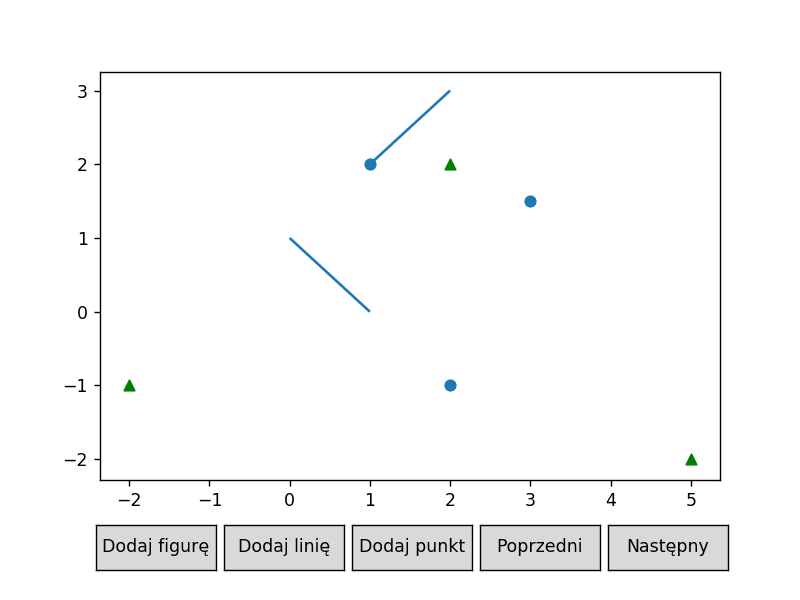

In [5]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


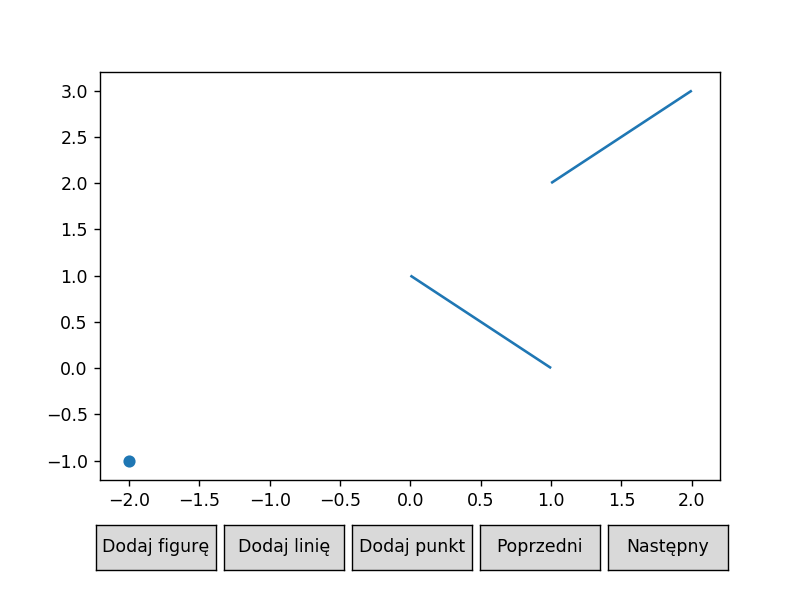

In [6]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


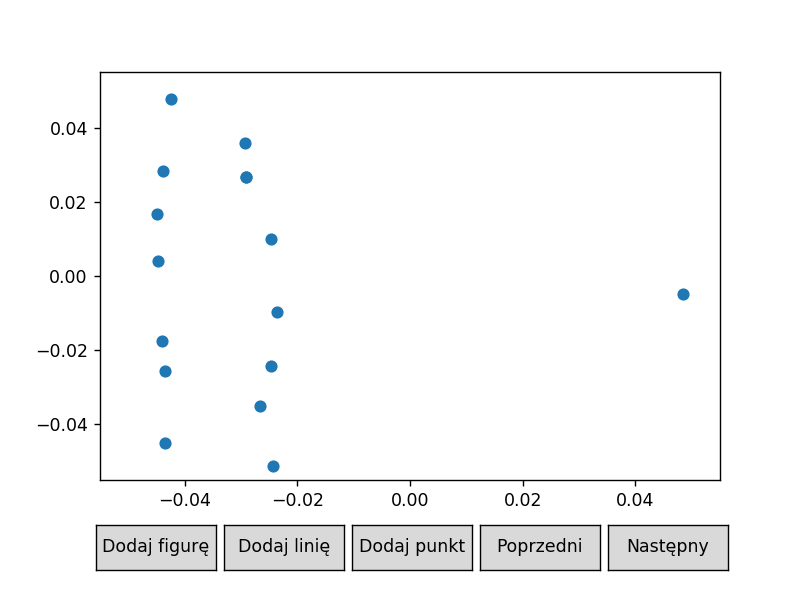

In [33]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


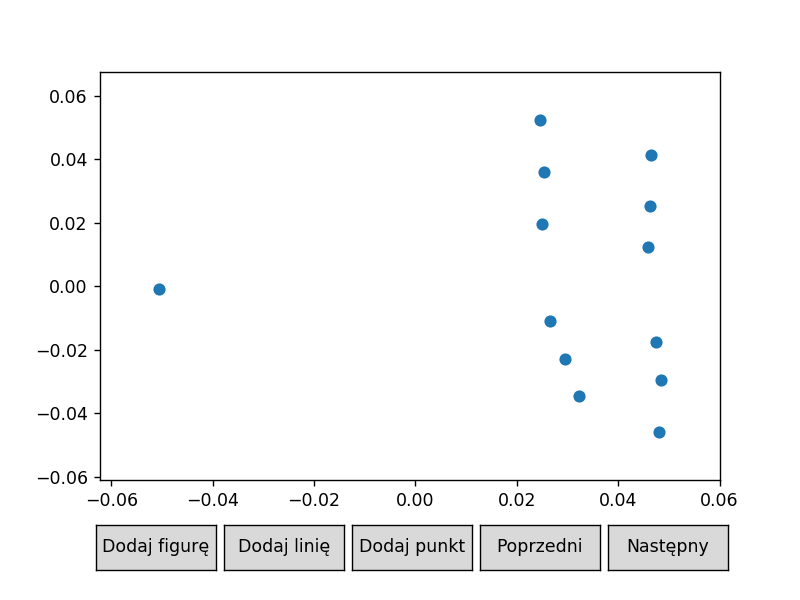

In [9]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


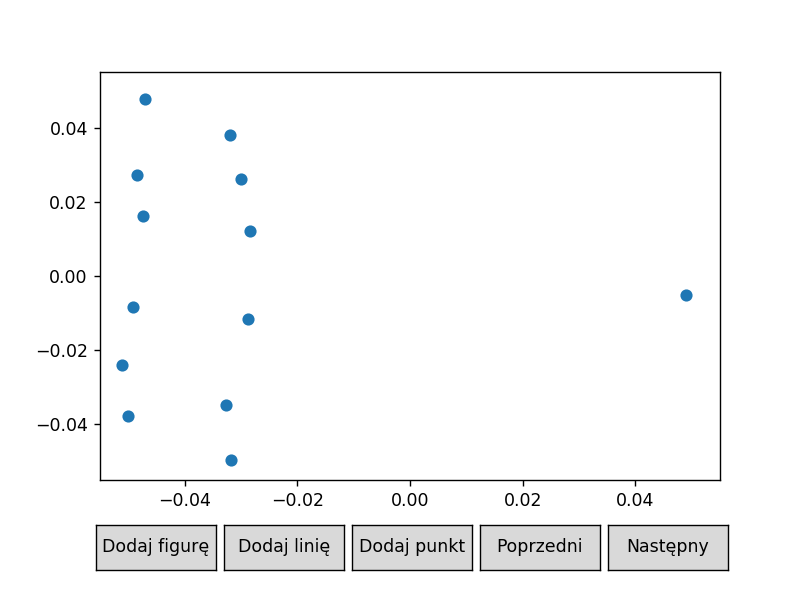

In [42]:
#Dodaj tu punkty, figury i/lub odcinki!
plotToAddThings = Plot()
plotToAddThings.draw()

In [43]:
points = []
for x in plotToAddThings.get_added_elements().points[0].points:
    points.append(x)
lines = [[points[x],points[(x+1)%len(points)]] for x in range(len(points))]

<IPython.core.display.Javascript object>


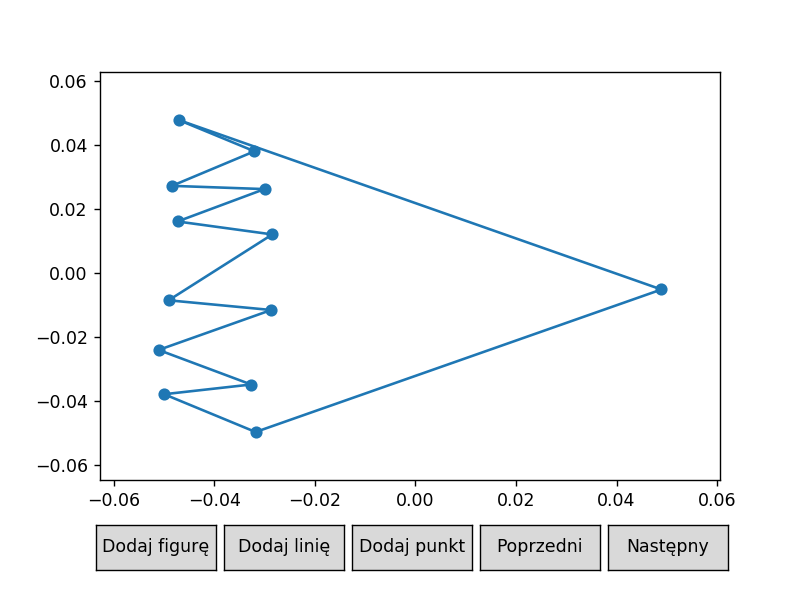

In [44]:
%matplotlib notebook

plot3 = Plot([Scene([PointsCollection(points)],[LinesCollection(lines)])])
plot3.draw()

## Write to file

In [37]:
def writeToFile(lines, fileName):
    scene = Scene([],[LinesCollection(lines)])
    plot = Plot([scene])
    
    with open(fileName, 'w') as file:
        file.write(plot.toJson())

def readLines(fileName):
    with open(fileName, 'r') as file:
        json = file.read()
        plot = Plot(json=json)
    return plot.scenes[0].lines[0].lines

def readPoints(fileName):
    with open(fileName, 'r') as file:
        json = file.read()
        plot = Plot(json=json)
    return plot.scenes[0].points[0].points

## Vertex class

In [14]:
from enum import Enum

class color(Enum):
    START = 1
    END = 2
    CORRECT = 3
    LINKING = 4
    DIVIDING = 5

class Vertex:
    def __init__(self, point, color = None):
        self.point = point
        self.color = color
        
    def __eq__(self,other):
        if self.point == other.point:
            return True
        return False
    
    def __lt__(self,other):
        if self.point[1] < other.point[1]:
            return True
        return False
    
    def __gt__(self,other):
        if self.point[1] > other.point[1]:
            return True
        return False
    
# get vertices from points
def getListOfVertices(points):
    Vertices = []
    for x in points:
        Vertices.append(Vertex(x))
    return Vertices

In [15]:
#funtions that return the highest and lowest vertex
def getMax(points):
    maxPoint = Vertex((-float("inf"),-float("inf")))
    for x in points:
        if x > maxPoint:
            maxPoint = x
    return maxPoint
def getMin(points):
    minPoint = Vertex((float("inf"),float("inf")))
    for x in points:
        if x < minPoint:
            minPoint = x
    return minPoint


def determiner1(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - a[0]*c[1] - a[1]*b[0] - b[1]*c[0]


## Checking monotonity and dividing in 2 subchains

In [38]:
def checkMonotonity(points):
    #searching for max and min vertex
    vertexList = getListOfVertices(points)
    MaxPointIndex = vertexList.index(getMax(vertexList))
    MinPointIndex = vertexList.index(getMin(vertexList))
    #dividing figure into 2 chains
    if MaxPointIndex < MinPointIndex:
        leftChain = vertexList[MaxPointIndex:MinPointIndex]
        rightChain = vertexList[MinPointIndex:] + vertexList[:MaxPointIndex]
    else:
        leftChain = vertexList[MaxPointIndex:] + vertexList[:MinPointIndex]
        rightChain = vertexList[MinPointIndex:MaxPointIndex]
    #checking the monotonity of the chain of vertices
    for x in  range(len(leftChain)-1):
        if leftChain[x] < leftChain[x+1]: return False
    for x in  range(len(rightChain)-1):
        if rightChain[x] > rightChain[x+1]: return False
    return True, leftChain, rightChain
        

## Coloring Vertices

In [39]:
#calculate colors
def setColor(vertex, prevVertex, nextVertex):
    if (prevVertex > vertex and nextVertex < vertex) or (prevVertex < vertex and nextVertex > vertex) or prevVertex == vertex or nextVertex == vertex: 
        vertex.color = color.CORRECT
        return
    detResult = determiner1(prevVertex.point, vertex.point, nextVertex.point)
    if prevVertex > vertex and nextVertex > vertex:
        if  detResult < 1e-8: vertex.color = color.LINKING
        else: vertex.color = color.END
    else :
        if detResult < 1e-8: vertex.color = color.DIVIDING
        else: vertex.color = color.START
    

In [40]:
def colorVertices(vertices):
    for x in range(len(vertices)):
        setColor(vertices[x],vertices[x-1],vertices[(x+1)%len(vertices)])
        

In [45]:
result, leftChain, rightChain = checkMonotonity(points)
print(result)

True


## Visualizing colored vertices

In [46]:
def classifyVertices(points):
    vertices = getListOfVertices(points)
    colorVertices(vertices)
    CorrectPoints = [x.point for x in vertices if x.color == color.CORRECT]
    StartPoints = [x.point for x in vertices if x.color == color.START]
    EndPoints = [x.point for x in vertices if x.color == color.END]
    LinkingPoints = [x.point for x in vertices if x.color == color.LINKING]
    DividingPoints = [x.point for x in vertices if x.color == color.DIVIDING]
    return [PointsCollection(CorrectPoints,color = "Brown"),
            PointsCollection(StartPoints,color="Green"),
            PointsCollection(EndPoints,color="Red"),
            PointsCollection(LinkingPoints,color="Blue"),
            PointsCollection(DividingPoints,color="Grey")]

<IPython.core.display.Javascript object>


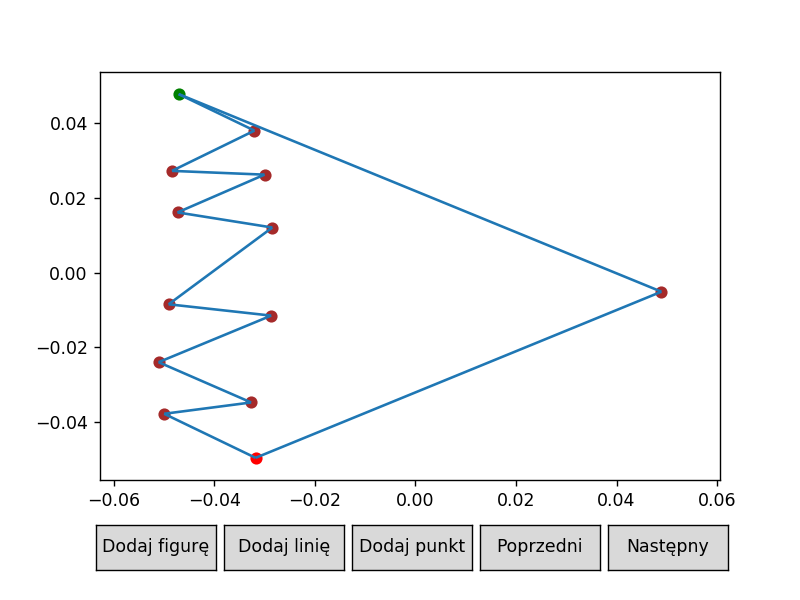

In [47]:
coloredPoints = classifyVertices(points)
plot = Plot([Scene(coloredPoints,[LinesCollection(lines)])])
plot.draw()

## Triangulation chain class

In [22]:
# code added not to repaet the same code for determinant
class Chain(Enum):
    LEFT = 1
    RIGHT = -1

class chainElement:
    def __init__(self,vertex,chain=None,index=None):
        self.index = index
        self.vertex = vertex
        self.chain = chain
    def __lt__(self,other):
        if (self.vertex < other.vertex): return True
        return False
    def __eq__(self,other):
        if (self.vertex == other.vertex): return True
        return False
    def __gt__(self,other):
        if (self.vertex > other.vertex): return True
        return False

In [23]:
def triangulate(points):
    vertexList = getListOfVertices(points)
    initialLines = [[points[x],points[(x+1)%len(points)]] for x in range(len(points))]
    
    monotonous, leftChain, rightChain = checkMonotonity(points)
        
    if monotonous:
        #initialize and sort chain elements lists
        chainSegments = [chainElement(x,Chain.LEFT) for x in leftChain]
        chainSegments += [chainElement(x,Chain.RIGHT) for x in rightChain]
        chainSegments.sort()
        chainSegments.reverse()
        
        triangulateLineToFile = []
        for id,x in enumerate(chainSegments):
            x.index = id
            triangulateLineToFile.append(x.vertex.point)
        
        #initialize stack
        lines = set()
        stack = []
        stack.append(chainSegments.pop(0))
        stack.append(chainSegments.pop(0))

        
        triangles = []
        
        while chainSegments:
            curVertex = chainSegments.pop(0)
            stackTop = stack[-1]
            
            #vertex on the other chain
            if (curVertex.chain != stackTop.chain):
                i = 0
                while(stack):
                    vertexToLink = stack.pop()
                    lines.add((curVertex.vertex.point,vertexToLink.vertex.point))
                    if not i == 0: triangles[-1].append(vertexToLink.index)
                    if stack : triangles.append([curVertex.index, vertexToLink.index])
                    i += 1

                stack.append(stackTop)
                stack.append(curVertex)
            
            #vertex on the same chain
            else:
                while True:
                    papaVertex = stack.pop()
                    if not stack:
                        stack.append(papaVertex)
                        stack.append(curVertex)
                        break
                    grandpaVertex = stack.pop()
                    #triangle inside of figure
                    if(determiner1(curVertex.vertex.point,papaVertex.vertex.point,grandpaVertex.vertex.point) * curVertex.chain.value < 1e-8):
                        lines.add((curVertex.vertex.point, grandpaVertex.vertex.point))
                        stack.append(grandpaVertex)
                        triangles.append([curVertex.index, grandpaVertex.index, papaVertex.index])
                    #triangle outside of figure
                    else:
                        stack.append(grandpaVertex)
                        stack.append(papaVertex)
                        stack.append(curVertex)
                        break


        triangulateLines = [list(x) for x in lines]
        for x in triangulateLines:
            if x in initialLines:
                triangulateLines.remove(x)
        TriangulateStructure = [triangulateLineToFile, triangles]
        return triangulateLines,TriangulateStructure
    
    return False
            
            
        
        

<IPython.core.display.Javascript object>


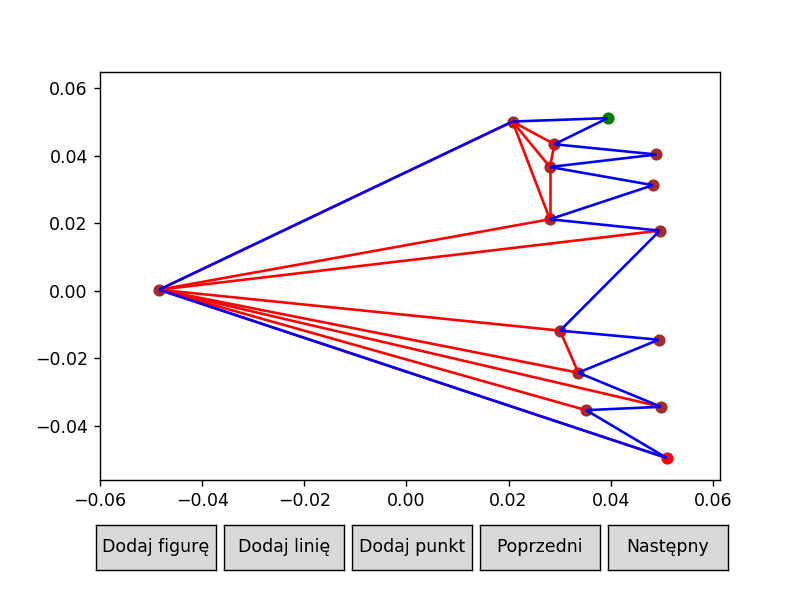

In [32]:


triangulateLines, triangles = triangulate(points)
# structure ready to write to file
for x in triangles[1]:
    if determiner1(triangles[0][x[0]],triangles[0][x[1]],triangles[0][x[2]]) < 0:
        temp = x[2]
        x[2]=x[1]
        x[1] = temp

linecol = LinesCollection(triangulateLines,color = "Red")


coloredPoints = classifyVertices(points)
plot = Plot([Scene(coloredPoints,[linecol,LinesCollection(lines,color = "Blue")])])
plot.draw()

<IPython.core.display.Javascript object>


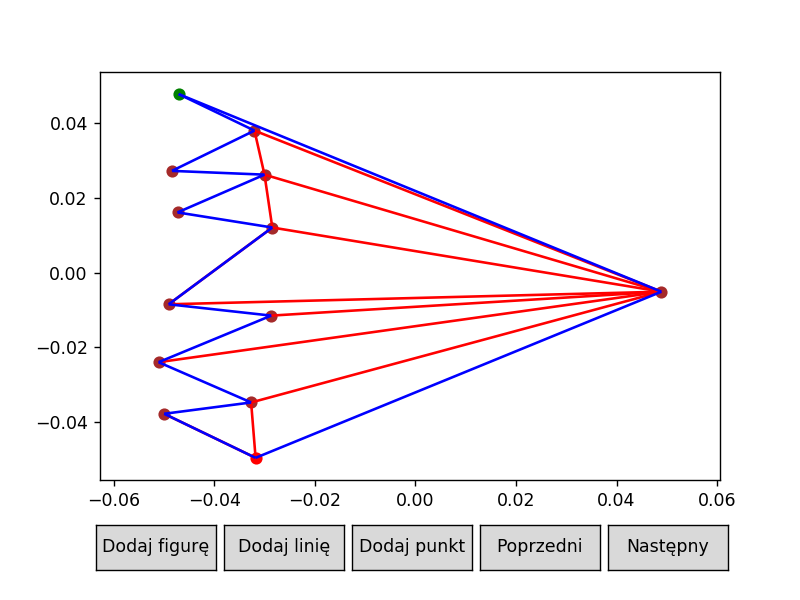

In [49]:
triangulateLines, triangles = triangulate(points)
# structure ready to write to file
for x in triangles[1]:
    if determiner1(triangles[0][x[0]],triangles[0][x[1]],triangles[0][x[2]]) < 0:
        temp = x[2]
        x[2]=x[1]
        x[1] = temp

linecol = LinesCollection(triangulateLines,color = "Red")


coloredPoints = classifyVertices(points)
plot = Plot([Scene(coloredPoints,[linecol,LinesCollection(lines,color = "Blue")])])
plot.draw()

In [27]:
import copy

def triangulateVisualize(points):
    vertexList = getListOfVertices(points)
    initialLines = [[points[x],points[(x+1)%len(points)]] for x in range(len(points))]
    
    MaxPointIndex = vertexList.index(getMax(vertexList))
    MinPointIndex = vertexList.index(getMin(vertexList))
    if MaxPointIndex < MinPointIndex:
        leftChain = vertexList[MaxPointIndex:MinPointIndex]
        rightChain = vertexList[MinPointIndex:] + vertexList[:MaxPointIndex]
    else:
        leftChain = vertexList[MaxPointIndex:] + vertexList[:MinPointIndex]
        rightChain = vertexList[MinPointIndex:MaxPointIndex]
        
    chainSegments = [chainElement(x,Chain.LEFT) for x in leftChain]
    chainSegments += [chainElement(x,Chain.RIGHT) for x in rightChain]
    chainSegments.sort()
    chainSegments.reverse()

    lines = set()
    stack = []
    stack.append(chainSegments.pop(0))
    stack.append(chainSegments.pop(0))
    
    scenes = []
    
    while chainSegments:
        curVertex = chainSegments.pop(0)
        stackTop = stack[-1]
        
        scenes.append(Scene([PointsCollection(points),
                             PointsCollection(copy.deepcopy([x.vertex.point for x in stack]),color = "Yellow"),
                             PointsCollection(copy.deepcopy([curVertex.vertex.point]),color = "Red")],
                           [
                            LinesCollection([list(x) for x in lines],color = "pink"),
                           LinesCollection(initialLines)]))
        
        
        if (curVertex.chain != stackTop.chain):
            while(stack):
                vertexToLink = stack.pop()
                lines.add((curVertex.vertex.point,vertexToLink.vertex.point))
                scenes.append(Scene([PointsCollection(points),
                             PointsCollection(copy.deepcopy([x.vertex.point for x in stack]),color = "Yellow"),
                             PointsCollection(copy.deepcopy([curVertex.vertex.point]),color = "Red")],
                           [
                            LinesCollection([list(x) for x in lines],color = "pink"),
                           LinesCollection(initialLines)]))
            stack.append(stackTop)
            stack.append(curVertex)
            scenes.append(Scene([PointsCollection(points),
                             PointsCollection(copy.deepcopy([x.vertex.point for x in stack]),color = "Yellow"),
                             PointsCollection(copy.deepcopy([curVertex.vertex.point]),color = "Red")],
                           [
                            LinesCollection([list(x) for x in lines],color = "pink"),
                           LinesCollection(initialLines)]))
            
        else:
            while True:
                papaVertex = stack.pop()
                if not stack:
                    stack.append(papaVertex)
                    stack.append(curVertex)
                    break
                grandpaVertex = stack.pop()
                scenes.append(Scene([PointsCollection(points),
                             PointsCollection(copy.deepcopy([x.vertex.point for x in stack]),color = "Yellow"),
                             PointsCollection(copy.deepcopy([curVertex.vertex.point]),color = "Red")],
                           [
                            LinesCollection([list(x) for x in lines],color = "pink"),
                           LinesCollection(initialLines)]))
                if(papaVertex.chain == Chain.LEFT):
                    if(determiner1(curVertex.vertex.point,papaVertex.vertex.point,grandpaVertex.vertex.point) < 1e-8):
                        lines.add((curVertex.vertex.point, grandpaVertex.vertex.point))
                        scenes.append(Scene([PointsCollection(points),
                             PointsCollection(copy.deepcopy([x.vertex.point for x in stack]),color = "Yellow"),
                             PointsCollection(copy.deepcopy([curVertex.vertex.point]),color = "Red")],
                           [
                            LinesCollection([list(x) for x in lines],color = "pink"),
                           LinesCollection(initialLines)]))
                        stack.append(grandpaVertex)
                    else:
                        stack.append(grandpaVertex)
                        stack.append(papaVertex)
                        stack.append(curVertex)
                        break
                else:
                    if(determiner1(curVertex.vertex.point,papaVertex.vertex.point,grandpaVertex.vertex.point) > 1e-8):
                        lines.add((curVertex.vertex.point, grandpaVertex.vertex.point))
                        scenes.append(Scene([PointsCollection(points),
                             PointsCollection(copy.deepcopy([x.vertex.point for x in stack]),color = "Yellow"),
                             PointsCollection(copy.deepcopy([curVertex.vertex.point]),color = "Red")],
                           [
                            LinesCollection([list(x) for x in lines],color = "pink"),
                           LinesCollection(initialLines)]))
                        stack.append(grandpaVertex)
                    else:
                        stack.append(grandpaVertex)
                        stack.append(papaVertex)
                        stack.append(curVertex)
                        break
        scenes.append(Scene([PointsCollection(points),
                             PointsCollection(copy.deepcopy([x.vertex.point for x in stack]),color = "Yellow"),
                             PointsCollection(copy.deepcopy([curVertex.vertex.point]),color = "Red")],
                           [LinesCollection([list(x) for x in lines],color = "pink"),
                           LinesCollection(initialLines)]))
    triangulateLines = [list(x) for x in lines]
    for x in triangulateLines:
        if x in initialLines:
            triangulateLines.remove(x)
    return scenes
            
            
        
        

<IPython.core.display.Javascript object>


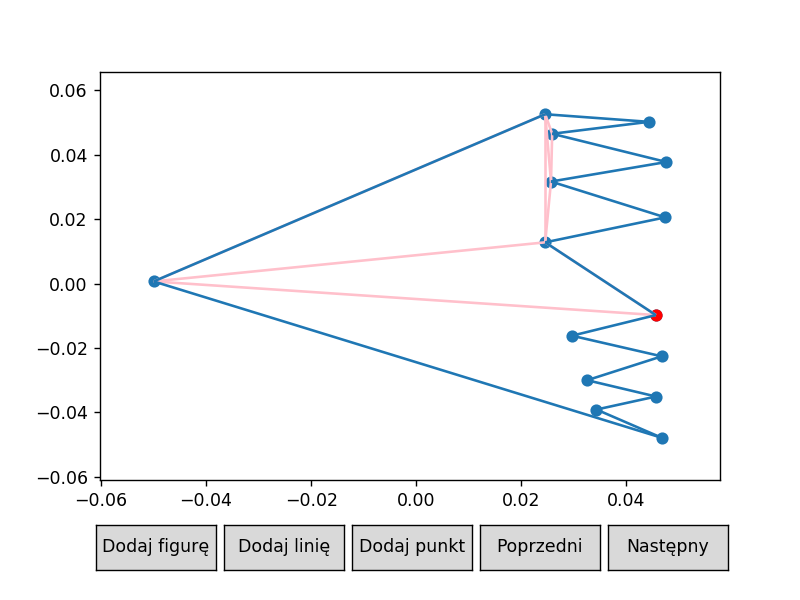

In [28]:
scenes = triangulateVisualize(points)
plot1 = Plot(scenes)
plot1.draw()

<IPython.core.display.Javascript object>


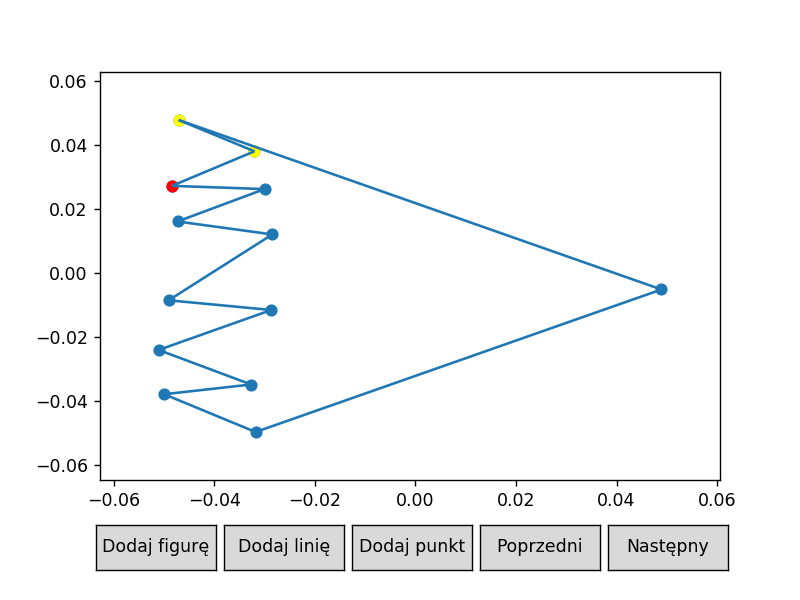

In [50]:
scenes = triangulateVisualize(points)
plot1 = Plot(scenes)
plot1.draw()